# Predicting Newsletter Subscription from Minecraft Gameplay Behavior
DSCI 100 – Group 11 Final Report


## Introduction


#### Background

Newsletters are commonly used in games to share updates and community information.
Some players choose to subscribe while others do not, and this difference may relate to player characteristics.
Our goal was to explore whether simple demographic information collected from players of `PLAICraft.ai` could help explain subscription behaviour.

#### Research Questions

`Broad Question`: 

What player characteristics and behaviors are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

`Specific Question`: 

Can Age and Experience predict subscription rate?

#### Dataset
The `player.csv`  dataset contains information describing the users. It is contains 196 observations (users) and 7 variables about them. 

*Table 1.1:*
| Variable | Type | Meaning |  |
|---|---|---|---|
experience | chr | experience level of player | "Pro", "Veteran", "Regular", "Amateur", "Beginner" |
subscribe | lgl| player is subscribed to newsletter or not | TRUE or FALSE |
hashedEmail | chr | player email as identifier | hashed for anonymity
played_hours | dbl | total hours played in game |
name | chr | player name |
gender | chr | player gender | Male, Female, Non-binary, Two-Spirited, Agender, Other, Prefer not to say |
Age | dbl | player age | 9 - 58 |

In [35]:
library(tidyverse)
library(tidymodels)
library(themis)
library(cowplot)

In [21]:
player_data <- read_csv("https://raw.githubusercontent.com/PraiseBeTheSun/DSCI-100-GROUP-PROJECT/refs/heads/main/data/players.csv")
session_data <- read_csv("https://raw.githubusercontent.com/PraiseBeTheSun/DSCI-100-GROUP-PROJECT/refs/heads/main/data/sessions.csv")

player_data <- player_data |>
filter(Age != is.na(Age)) |>
mutate(subscribe = as.factor(subscribe),
       experience = as.factor(experience))


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Players.csv Summary

In [22]:
player_data_age_hours <- select(player_data,played_hours, Age)

player_data_numeric_summaries <- 
    bind_cols(summary = c("Mean","Minimum","Maximum", "Standard Deviation", "Mode",
                          "1st Quartile", "2nd Quartile", "3rd Quartile"),
              bind_rows(map_df(player_data_age_hours, mean, na.rm = TRUE), #mean
                        map_df(player_data_age_hours, range, na.rm = TRUE), #min + max
                        map_df(player_data_age_hours, sd, na.rm = TRUE), #std dev
                        
                        bind_cols(played_hours = group_by(player_data_age_hours, played_hours) |>  #mode
                                          summarize(count = n()) |>slice_max(count) |> pull(played_hours), 
                                  Age = group_by(player_data_age_hours, Age) |> summarize(count = n()) |>
                                          slice_max(count) |> pull(Age)),
                        tibble(played_hours = quantile(pull(player_data_age_hours,played_hours), #quartiles
                                                       c(0.25, 0.5, 0.75), na.rm = TRUE),
                               Age = quantile(pull(player_data_age_hours,Age), 
                                              c(0.25, 0.5, 0.75), na.rm = TRUE)))) |>
    mutate(across(played_hours:Age, round, 2)) #rounding

player_data_numeric_summaries

summary,played_hours,Age
<chr>,<dbl>,<dbl>
Mean,5.9,21.14
Minimum,0.0,9.00
Maximum,223.1,58.00
Standard Deviation,28.5,7.39
Mode,0.0,17.00
1st Quartile,0.0,17.00
2nd Quartile,0.1,19.00
3rd Quartile,0.6,22.75


In [4]:
player_data_category <- select(player_data, experience, subscribe, gender)

experience_summary <- player_data_category |> group_by(experience) |> summarize(number = n()) |> arrange(-number) |>
                                mutate(percent_total = round(number/nrow(player_data_category)*100,2))
subscribe_summary <- player_data_category |> group_by(subscribe) |> summarize(number = n()) |> arrange(-number) |>
                                mutate(percent_total = round(number/nrow(player_data_category)*100,2))                      
gender_summary <- player_data_category |> group_by(gender) |> summarize(number = n()) |> arrange(-number) |>
                                mutate(percent_total = round(number/nrow(player_data_category)*100,2)) 

experience_summary
subscribe_summary
gender_summary

experience,number,percent_total
<fct>,<int>,<dbl>
Amateur,63,32.47
Veteran,48,24.74
Beginner,35,18.04
Regular,35,18.04
Pro,13,6.70


subscribe,number,percent_total
<fct>,<int>,<dbl>
TRUE,142,73.2
FALSE,52,26.8


gender,number,percent_total
<chr>,<int>,<dbl>
Male,124,63.92
Female,37,19.07
Non-binary,15,7.73
Prefer not to say,11,5.67
Two-Spirited,5,2.58
Agender,2,1.03


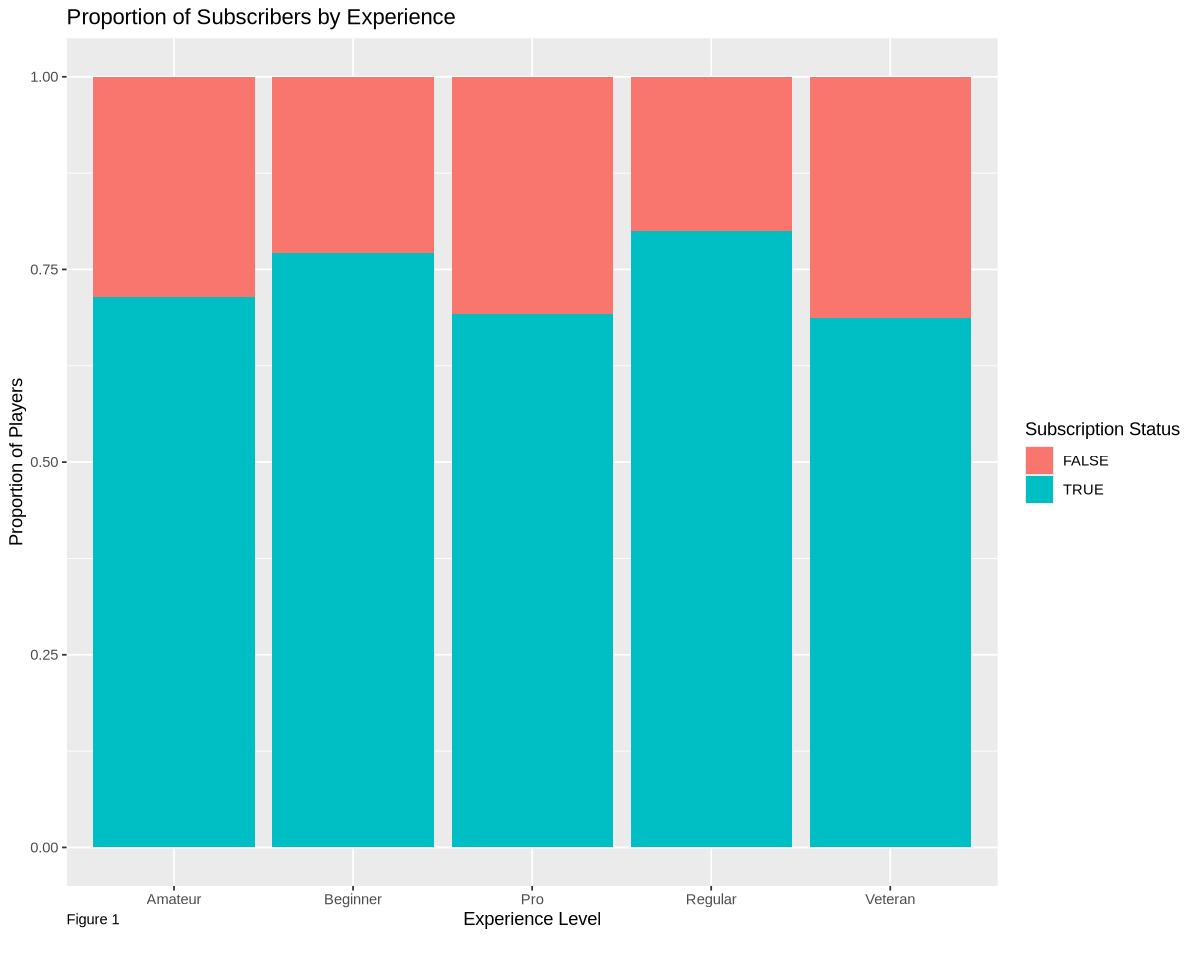

In [5]:
options(repr.plot.width = 10, repr.plot.height = 8)
ggplot(player_data, aes(x = experience, fill = subscribe)) +
geom_bar(position = "fill") +
labs(title = "Proportion of Subscribers by Experience", 
     x = "Experience Level", 
     y = "Proportion of Players",
    fill = "Subscription Status",
    caption = "Figure 1") +
theme(plot.caption = element_text(hjust = 0, vjust = 8))

### Experience vs Subscription — Count Plot

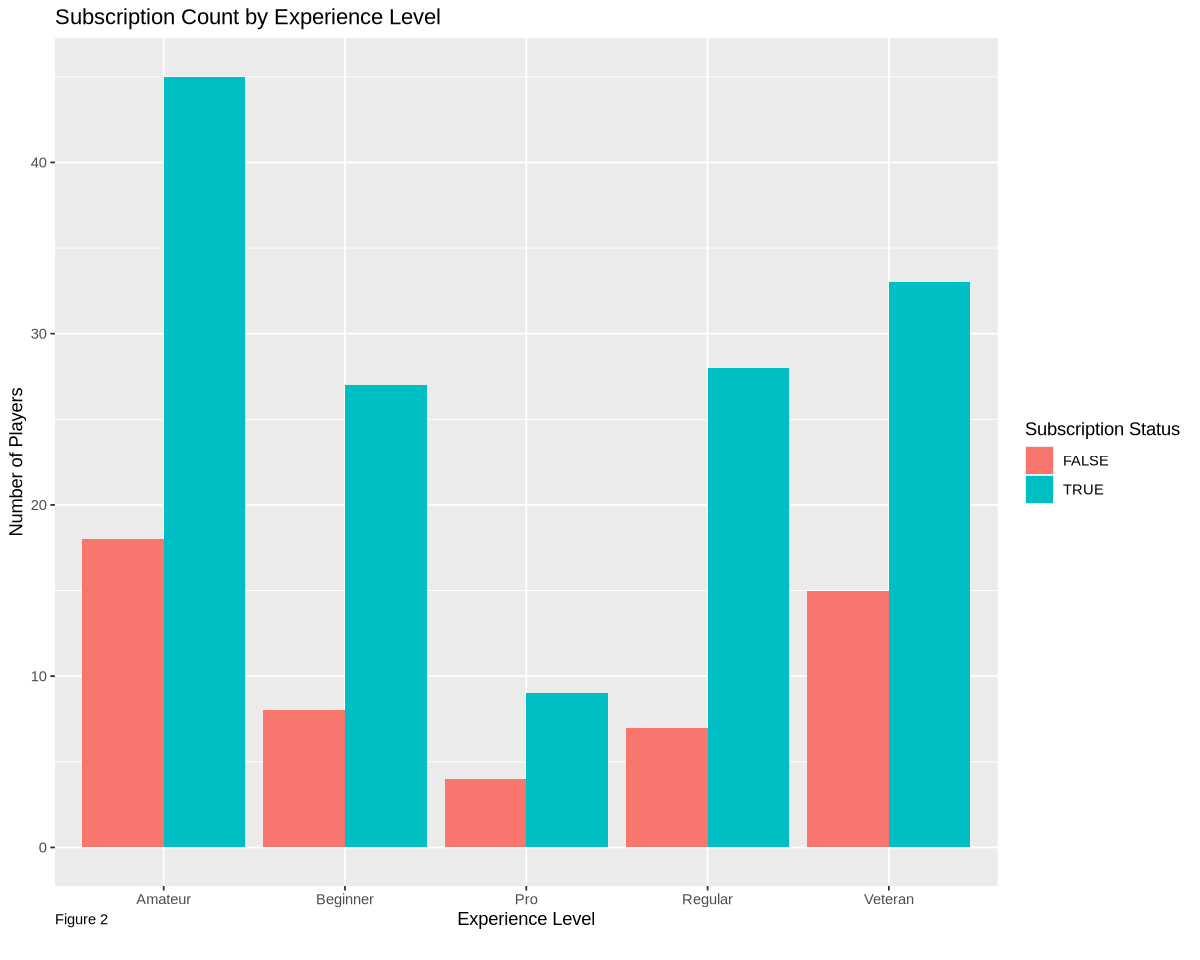

In [34]:
ggplot(player_data, aes(x = experience, fill = subscribe)) +
  geom_bar(position = "dodge") +
  labs(title = "Subscription Count by Experience Level",
       x = "Experience Level",
       y = "Number of Players",
      fill = "Subscription Status",
      caption = "Figure 2") +
theme(plot.caption = element_text(hjust = 0, vjust = 8))

### Summary Table

In [6]:
summary_table <- player_data |>
  summarize(
    n_players = n(),
    mean_age = mean(Age, na.rm = TRUE),
    median_age = median(Age, na.rm = TRUE),
    subscribe_rate = sum(subscribe == "TRUE") / n(),
    mean_hours_sub = mean(played_hours[subscribe == TRUE], na.rm = TRUE),
    mean_hours_nosub = mean(played_hours[subscribe == FALSE], na.rm = TRUE))
summary_table

n_players,mean_age,median_age,subscribe_rate,mean_hours_sub,mean_hours_nosub
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
194,21.13918,19,0.7319588,7.883099,0.5019231


#### Age vs Subscription

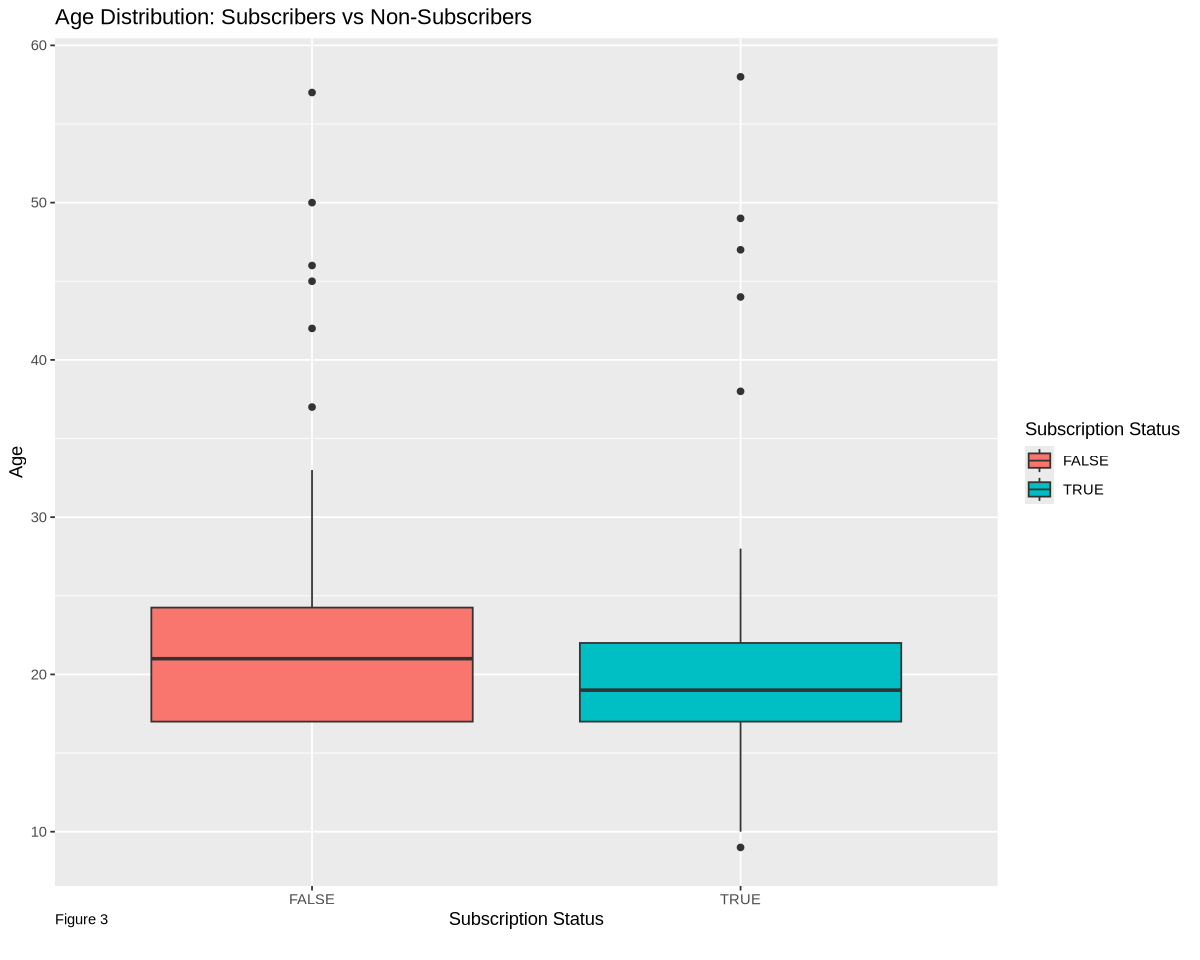

In [33]:
ggplot(player_data, aes(x = subscribe, y = Age, fill = subscribe)) +
  geom_boxplot() +
  labs(title = "Age Distribution: Subscribers vs Non-Subscribers",
       x = "Subscription Status",
       y = "Age",
       fill = "Subscription Status",
      caption = "Figure 3") +
theme(plot.caption = element_text(hjust = 0, vjust = 8))

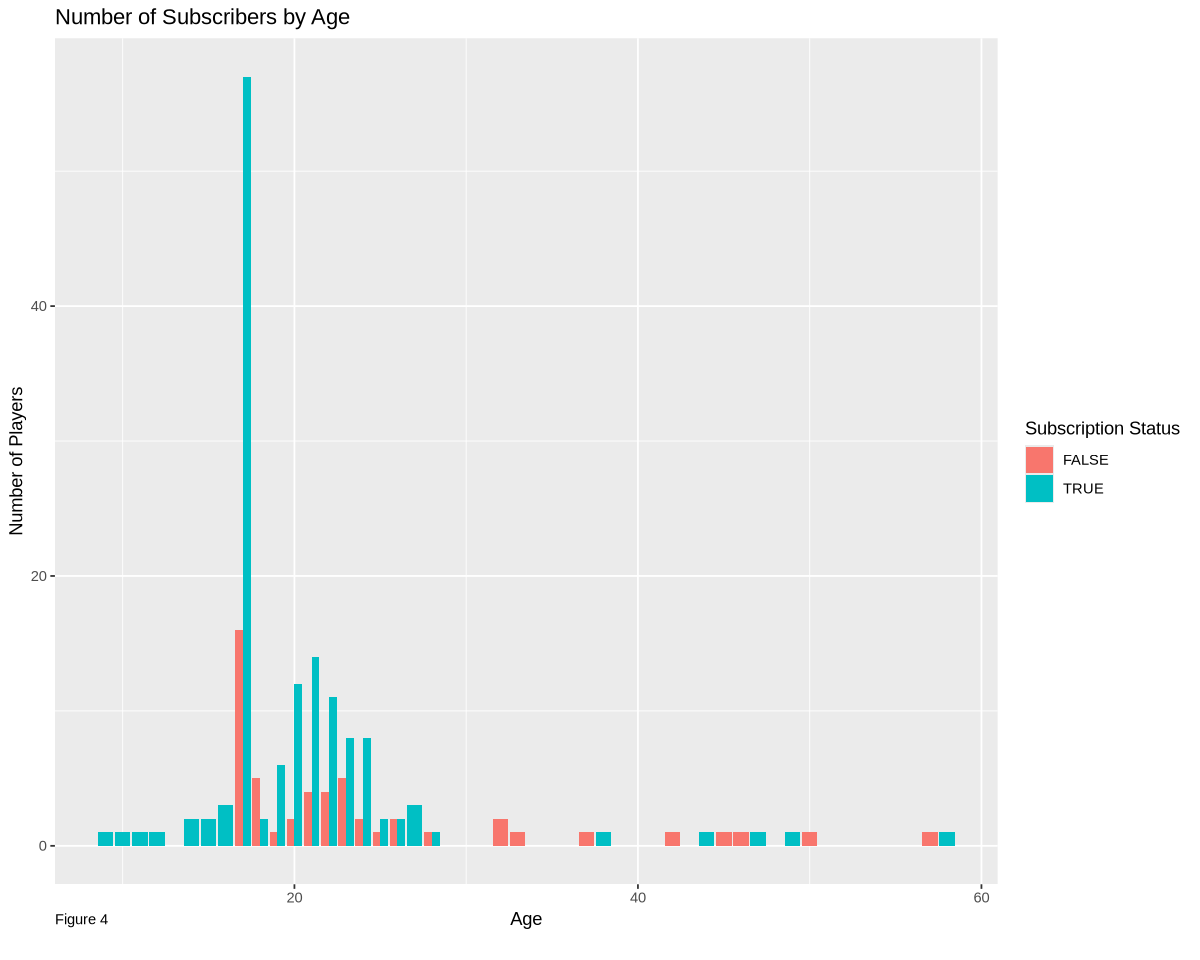

In [32]:
options(repr.plot.width = 10, repr.plot.height = 8)
ggplot(player_data, aes(x = Age, fill = subscribe)) +
geom_bar(position = "dodge") +
labs(title = "Number of Subscribers by Age", 
     x = "Age", 
     y = "Number of Players",
    fill = "Subscription Status",
    caption = "Figure 4") +
theme(plot.caption = element_text(hjust = 0, vjust = 8))

### Method and Results:
*Data Wrangling:*

- Removed rows with missing values
- Converted “subscribe” into a binary factor
- Converted “experience” into an ordered factor
- Standardized age predictor during modelling
- The KNN Classification model was used
- Upsampled to create a 1:1 between True and False for subscribe after the first KNN classification models were created

We used three models for forward selection comparison
- Age only
- Experience only
- Age and Experience

We tuned k-values from 1 to 100

#### Split and 5-fold Data Separation

In [9]:
set.seed(1)
player_split <- initial_split(player_data, prop = 0.75, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

player_vfold <- vfold_cv(player_train, v = 5, strata = subscribe)

Here we split the data into training and testing, readying for 5-fold data seperation

#### K-NN Classification Models

In [10]:
k_vals <- tibble(neighbors = seq(from = 1, to = 75, by = 2))

# manual forward selection
knn_recipe_age <- recipe(subscribe ~ Age, data = player_train) |>
                step_normalize(all_predictors())

knn_recipe_experience <- recipe(subscribe ~ experience, data = player_train)

knn_recipe_both <- recipe(subscribe ~ Age + experience, data = player_train) |>
                step_normalize(Age)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

age_tune <- workflow() |>
            add_recipe(knn_recipe_age) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 

experience_tune <- workflow() |>
            add_recipe(knn_recipe_experience) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 

both_tune <- workflow() |>
            add_recipe(knn_recipe_both) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 

Here we normalized/standardized all predictors, set our engine to `kknn` and mode to classification, and tuned.

#### K-NN Tune Model Plots

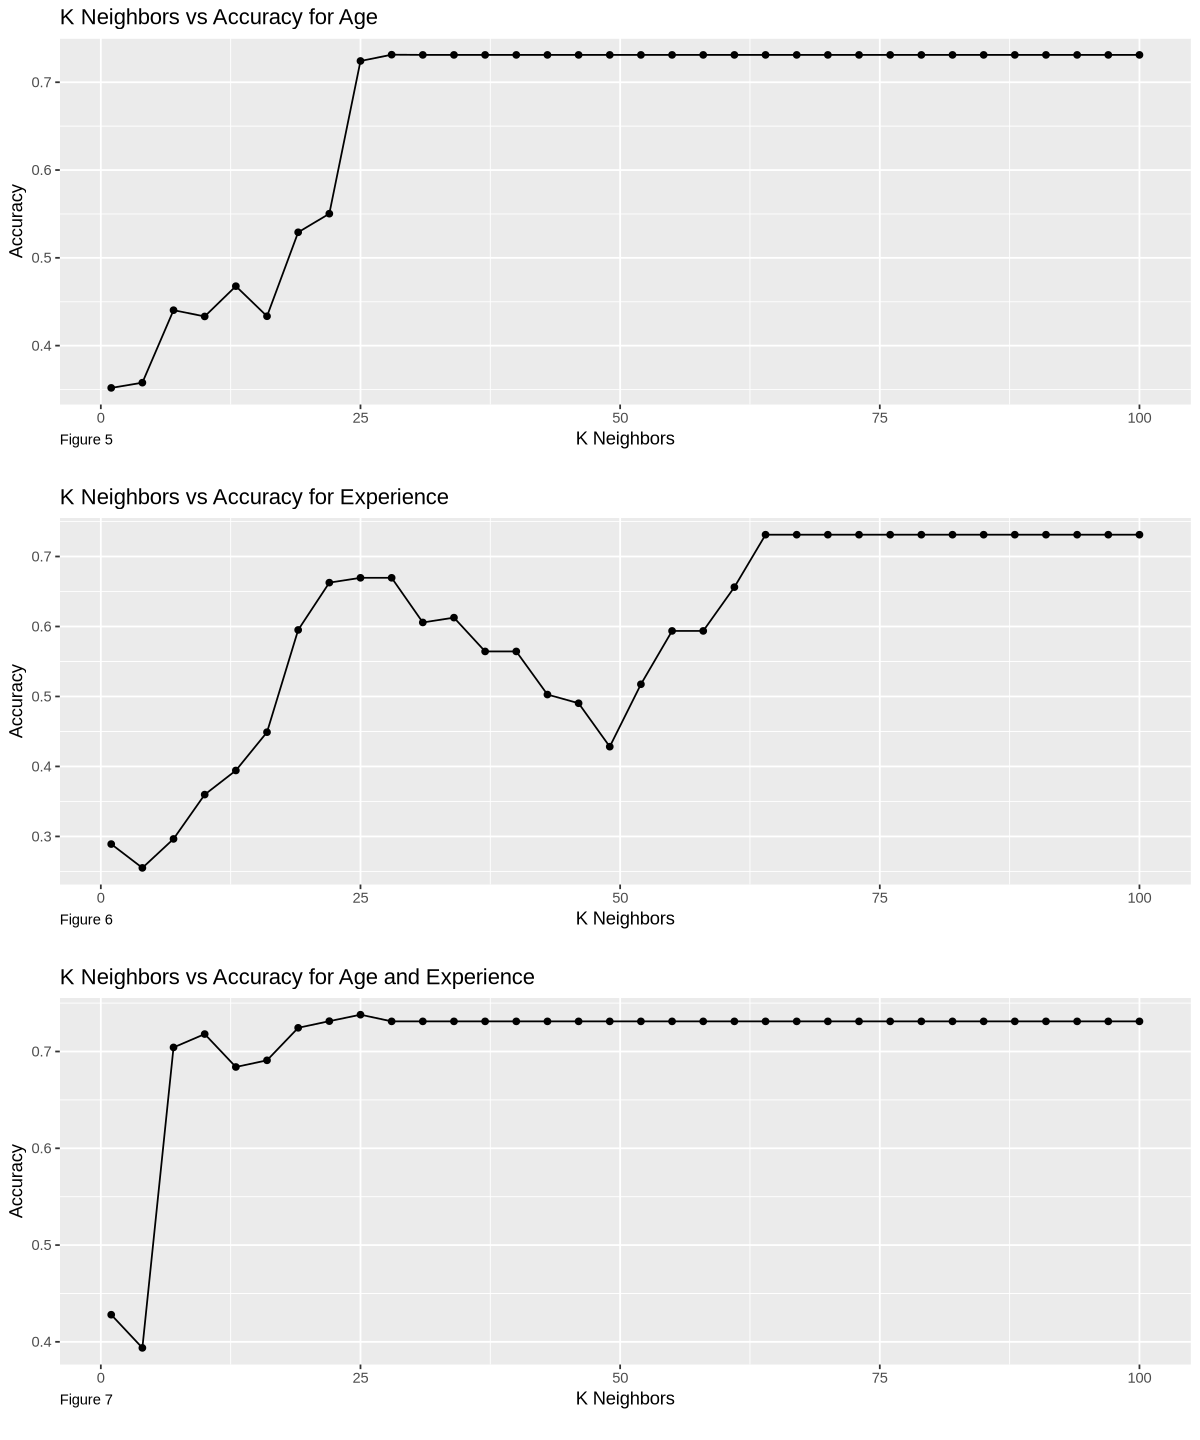

In [27]:
options(repr.plot.width = 10, repr.plot.height = 12)
age_tune_plot <- age_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(title = "K Neighbors vs Accuracy for Age",
                     x = "K Neighbors", y = "Accuracy", caption = "Figure 5") +
                theme(plot.caption = element_text(hjust = 0, vjust = 8))

experience_tune_plot <- experience_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(title = "K Neighbors vs Accuracy for Experience", 
                     x = "K Neighbors", y = "Accuracy", caption = "Figure 6") +
                theme(plot.caption = element_text(hjust = 0, vjust = 8))

both_tune_plot <- both_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(title = "K Neighbors vs Accuracy for Age and Experience",
                     x = "K Neighbors", y = "Accuracy", caption = "Figure 7") +
                theme(plot.caption = element_text(hjust = 0, vjust = 8))

plot_grid(age_tune_plot,
          experience_tune_plot,
          both_tune_plot, ncol = 1)


Here we plotted the K-Neighbors vs Accuracy plots for `Age`, `Experience`, and both `Age and Experience`

### Tuning Results
*Age Only Plot:*
- Accuracy peaks at K = 7 - 13
- As K increases past 13, accuracy seems to drop, and larger K values make the values too averaged.
- As K increases past 25, accuracy flattens out all the way to K = 75, indicating the model is underfitting.
- Age does not seem to separate subscribers from non-subscribers meaningfully

*Experience Only Plot:*
- Accuracy higher than the Age Only Plot
- Accuracy peaks at around K = 22
- As K increases past 22, accuracy drops, and larger K values make the value too averaged
- As K increases past 64, accuracy flattens out all the way to K = 75, indicating the model is underfitting.
- Experience seems to be more strongly connected to subscription, as the accuracy is higher. However, we must see the results after upsampling.

*Age and Experience Plot:*

- Highest overall accuracy value
- Accuracy peaks at around K = 9
- As K increases past 10, accuracy drops, and larger K values make the value too averaged
- As K increases past 19, accuracy flattens out all the way to K = 75, indicating the model is underfitting.
- Combined, both predictors seem to have improved performance, with accuracy being higher than just using `Age` or `Experience`

#### Select Predictors and K Value

In [12]:
max_age_accuracy <- age_tune |> 
                slice_max(mean)
max_experience_accuracy <- experience_tune |>
                        slice_max(mean)
max_both_accuracy <- both_tune |>
                    slice_max(mean)
# max_age_accuracy        # <- max accuracy = 0.7313793 @ 28 neighbors
# max_experience_accuracy # <- max accuracy = 0.7311494 @ 64-100 neighbors
# max_both_accuracy      # <- max accuracy = 0.738046 @ 25 neighbors

#### K-NN Model and Prediction

In [13]:
knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = 25) |>
                set_engine("kknn") |>
                set_mode("classification")

knn_fit <- workflow() |>
            add_recipe(knn_recipe_both) |>
            add_model(knn_spec_tuned) |>
            fit(player_train)


player_predict <- predict(knn_fit, player_test) |>
                bind_cols(player_test)


#### Confusion Matrix and Metrics

In [14]:
prediction_conf_mat <- player_predict |>
                        conf_mat(truth = subscribe, estimate = .pred_class)

prediction_accuracy <- player_predict |>
                        metrics(truth = subscribe, estimate = .pred_class) |>
                        filter(.metric == "accuracy")

prediction_precision <- player_predict |> # TRUE is the second event level
                        precision(truth = subscribe, estimate = .pred_class, event_level = "second")

prediction_recall <- player_predict |>
                        recall(truth = subscribe, estimate = .pred_class, event_level = "second")

prediction_conf_mat
bind_rows(prediction_accuracy, prediction_precision, prediction_recall)

          Truth
Prediction FALSE TRUE
     FALSE     0    1
     TRUE     13   35

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7142857
precision,binary,0.7291667
recall,binary,0.9722222


From the above confusion matrix, it can be seen that `TRUE` was predicted 48 out of 49 times, leading to an accuracy of 0.714. However, of the 49 predictions, only 35 where correct, and `False` was never predicted correctly; making this model worse than predicting `TRUE` for every observation regardless of `Age` and `experience`. The bias to only predicting `True` is most likely due to the imbalance of `TRUE` and `FALSE` values in `subscribe`, which can be addressed through upsampling.

#### Upsample Training Data and 5-fold Data Separation

In [15]:
set.seed(1)
player_train_upsampled <- recipe(subscribe ~ Age + experience, data = player_train) |>
                            step_upsample(subscribe, over_ratio = 1, skip = TRUE) |>
                             prep(retain = TRUE) |>
                             bake(new_data = NULL)

player_vfold_upsampled <- vfold_cv(player_train_upsampled, v = 5, strata = subscribe)

#### Upsampled K-NN Models

In [16]:
balanced_knn_recipe_age <- recipe(subscribe ~ Age, data = player_train_upsampled) |>
                            step_normalize(all_predictors())

balanced_knn_recipe_experience <- recipe(subscribe ~ experience, data = player_train_upsampled)

balanced_knn_recipe_both <- recipe(subscribe ~ Age + experience, data = player_train_upsampled) |>
                            step_normalize(Age)


balanced_age_tune <- workflow() |>
            add_recipe(balanced_knn_recipe_age) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold_upsampled, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 

balanced_experience_tune <- workflow() |>
            add_recipe(balanced_knn_recipe_experience) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold_upsampled, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 

balanced_both_tune <- workflow() |>
            add_recipe(balanced_knn_recipe_both) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold_upsampled, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 


#### K-NN Tune Model Plots of Upsampled

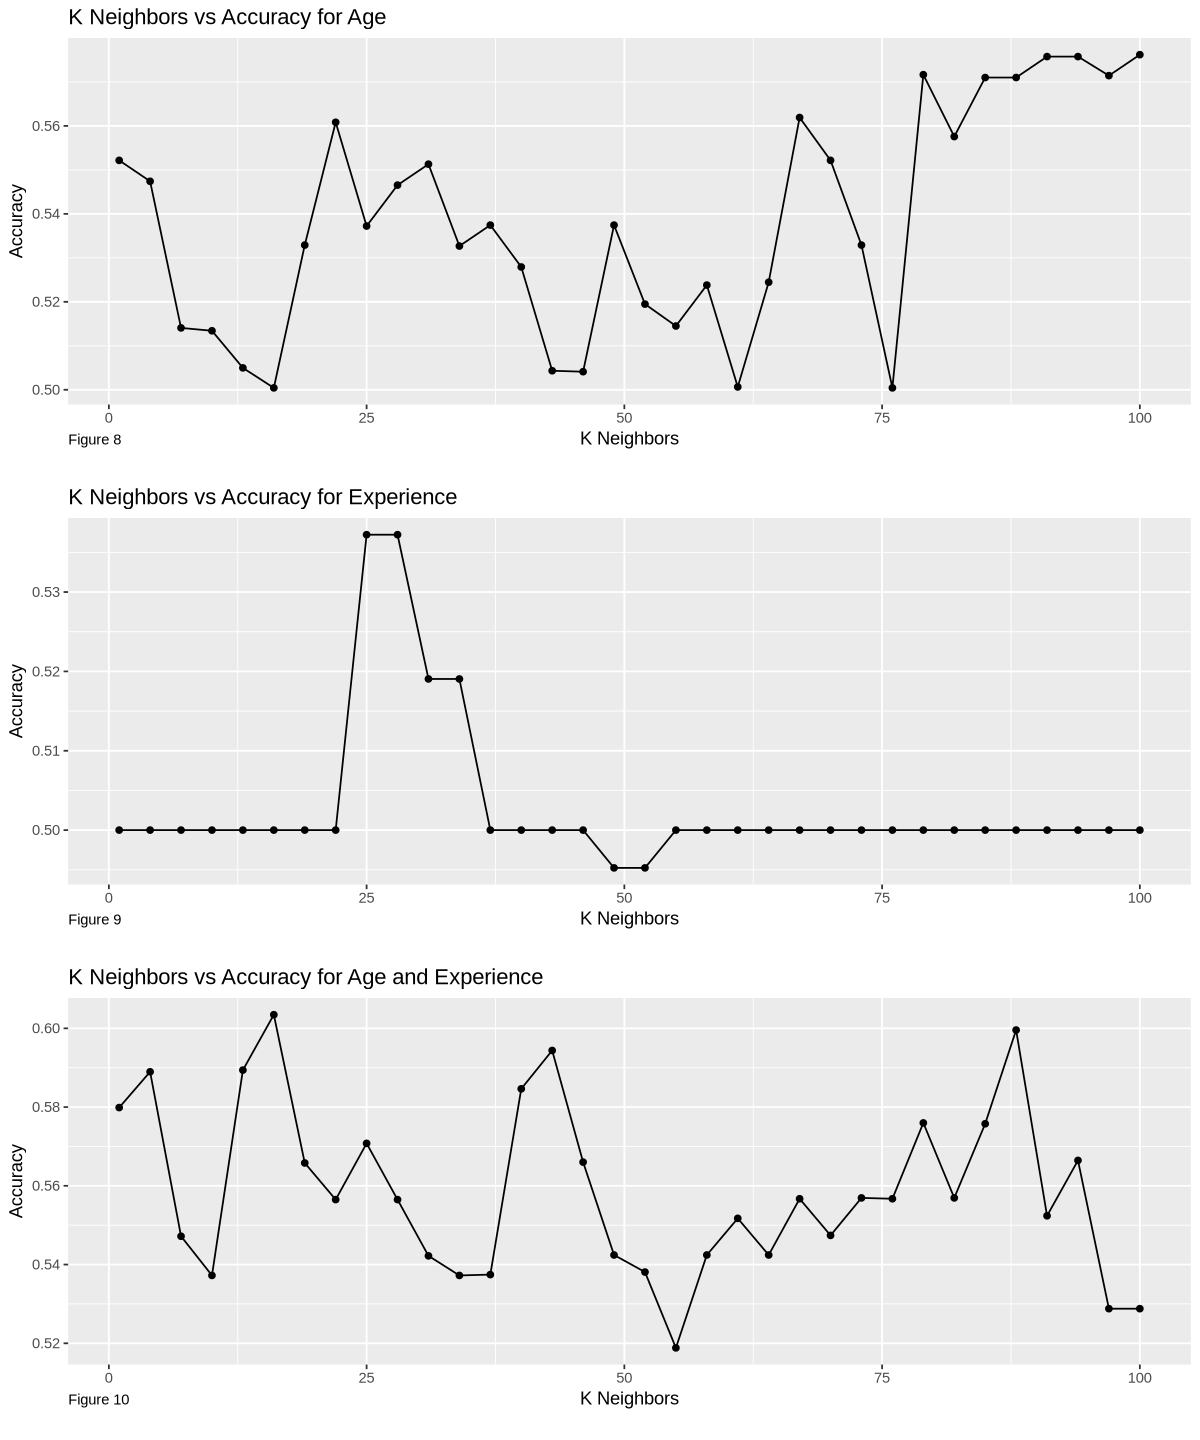

In [28]:
options(repr.plot.width = 10, repr.plot.height = 12)
balanced_age_tune_plot <- balanced_age_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(title = "K Neighbors vs Accuracy for Age",
                     x = "K Neighbors", y = "Accuracy", caption = "Figure 8") +
                theme(plot.caption = element_text(hjust = 0, vjust = 8))

balanced_experience_tune_plot <- balanced_experience_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(title = "K Neighbors vs Accuracy for Experience",
                     x = "K Neighbors", y = "Accuracy", caption = "Figure 9") +
                theme(plot.caption = element_text(hjust = 0, vjust = 8))

balanced_both_tune_plot <- balanced_both_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(title = "K Neighbors vs Accuracy for Age and Experience",
                     x = "K Neighbors", y = "Accuracy", caption = "Figure 10") +
                theme(plot.caption = element_text(hjust = 0, vjust = 8))

plot_grid(balanced_age_tune_plot,
          balanced_experience_tune_plot,
          balanced_both_tune_plot, ncol = 1)

After upsampling, our predictions differ a bit. Both predictors seem pretty weak, only being about 50-60% accurate. However, using both predictors gives us the highest accuracy of around 61% at K = 15, showing that the predictors do seem to have partial relation to subscription. Perhaps if the sample size was larger, we can confidently determine whether these variables are strong predictors or not.

#### Select Predictors and K Value of Upsampled

In [18]:
balanced_max_age_accuracy <- balanced_age_tune |> 
                slice_max(mean)
balanced_max_experience_accuracy <- balanced_experience_tune |>
                        slice_max(mean)
balanced_max_both_accuracy <- balanced_both_tune |>
                    slice_max(mean)
# balanced_max_age_accuracy        # <- max accuracy = 0.5761905 @ 28 neighbors
# balanced_max_experience_accuracy # <- max accuracy = 0.5372294 @ 25-28 neighbors
# balanced_max_both_accuracy       # <- max accuracy = 0.6034632 @ 25 neighbors

#### Upsampled K-NN Model and Prediction

In [19]:
balanced_knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) |>
                set_engine("kknn") |>
                set_mode("classification")

balanced_knn_fit <- workflow() |>
            add_recipe(balanced_knn_recipe_both) |>
            add_model(balanced_knn_spec_tuned) |>
            fit(player_train_upsampled)

balanced_player_predict <- predict(balanced_knn_fit, player_test) |>
                bind_cols(player_test)


#### Confusion Matrix and Metrics of Upsampled Model

In [20]:
balanced_prediction_conf_mat <- balanced_player_predict |>
                        conf_mat(truth = subscribe, estimate = .pred_class)

balanced_prediction_accuracy <- balanced_player_predict |>
                        metrics(truth = subscribe, estimate = .pred_class) |>
                        filter(.metric == "accuracy")

balanced_prediction_precision <- balanced_player_predict |> # TRUE is the second event level
                        precision(truth = subscribe, estimate = .pred_class, event_level = "second")

balanced_prediction_recall <- balanced_player_predict |>
                        recall(truth = subscribe, estimate = .pred_class, event_level = "second")

balanced_prediction_conf_mat
bind_rows(balanced_prediction_accuracy, balanced_prediction_precision, balanced_prediction_recall)

          Truth
Prediction FALSE TRUE
     FALSE    10   24
     TRUE      3   12

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.4489796
precision,binary,0.8000000
recall,binary,0.3333333


After upsampling to create a balance between `TRUE` and `FALSE` observations, the accuracy actually becomes worse than the accuracy of the unbalanced model. This is likely due to ... or the nature of the upsampling technique does not upsample the data in a way that in condusive to retaining the original relationships.

### Discussion:

*Summarize what you found:*
- We found that `Experience` and `Age` can seemingly predict newsletter subscription. We found that using both `Experience` and `Age` is the most accurate, followed by `Experience` alone, and then `Age` alone. However, after being upsampled, `Age` is around the same as `Experience`, both having abyssmally low accuracies of around 55%.

*Is this what we expected to find?:*
- This is expected, as in our individual project, visualizations showed that different `Experience` levels had very similar subscription proportions, meaning not much predictability between different experience levels. `Age` also seems pretty weak as a predictor, with a seemingly pretty weak relation with subscription.

*Discuss what impact such findings could have:*
- Advertisers can use this information to cater to a targeted age or gaming experience audience for Minecraft-related material.
- New studies can go more in-depth at the relation between Age and Experience level

*Discuss what future questions this could lead to:*
- Can `gender` or `played_hours` also predict newsletter subscription?